In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install -q torchvision pandas codetiming
# %matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [3]:
from charts.common.dataset import LabeledImage
from charts.common.timer import Timer

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision.transforms import ToTensor, ToPILImage
from torchvision import transforms

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

import os
from pathlib import Path

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

display(f"Use CUDA: {use_cuda}")

'Use CUDA: True'

In [16]:
class ColorRegressionImageDataset(Dataset):
    def __init__(self, img_dir, transform=ToTensor(), target_transform=ToTensor()):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        json_files = sorted(img_dir.glob("img-?????-???.json"))
        self.labeled_images = list(map(LabeledImage, json_files))

    def __len__(self):
        return len(self.labeled_images)

    def __getitem__(self, idx):
        labeled_img = self.labeled_images[idx]
        labeled_img.ensure_images_loaded()
        image = labeled_img.rendered_image
        labels_image = labeled_img.labels_as_rgb
        labeled_img.release_images()
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels_image = self.target_transform(labels_image)
        assert (image is not None)
        return image, labels_image, repr(self.labeled_images[idx])

    def __repr__(self):
        return f"{len(self)} images, first is {self.labeled_images[0]}, last is {self.labeled_images[-1]}"

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def denormalized_clipped_tensor_image (im):
    return torch.clip(im * 0.5 + 0.5, 0.0, 1.0)

def denormalized_numpy_image_from_tensor (im):
    return denormalized_clipped_tensor_image(im).permute(1, 2, 0).detach().cpu().numpy()

dataset = ColorRegressionImageDataset(Path('../../generated/drawings'), transform=transform, target_transform=transform)
n_train = max(len(dataset) // 2, 1)
n_test = len(dataset) - n_train
train_dataset, test_dataset = random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(42))

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [19]:
monitored_json = train_dataset[0][2]

In [20]:
class RegressionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.downThenUp = nn.Sequential(
            nn.Conv2d(3, 16, 5, padding='same'),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 5, padding='same'),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.Conv2d(16, 16, 5, padding='same'),
            nn.ReLU(inplace=True),
        )

        # self.final_conv = nn.Conv2d(16 + 3, 32, 5, padding='same')
        self.final_conv = nn.Sequential (
            # +3 do to the concatenation.
            nn.Conv2d(16 + 3, 32, 5, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 3, 5, padding='same')
        )

        # # self.conv1.weight.data[...] = 1.0 / (5*5)
        # nn.init.constant_(self.conv1.bias, 0.0)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.up = nn.ConvTranspose2d(6, 3, kernel_size=2, stride=2)
        # # nn.init.constant_(self.up.weight, 0.001)
        # nn.init.constant_(self.up.bias, 0.0)

    def combine(self, x1, x2):
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return x

    def forward(self, x):
        # x = self.pool(self.conv1(x))
        # x = self.up(x)
        x_features = self.downThenUp(x)
        x = self.combine(x_features, x)
        x = self.final_conv(x)
        return x

def compute_loss (net, loader):
    with torch.no_grad():
        running_loss = 0.0
        for data in loader:
            inputs, labels, _ = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(loader)

net = RegressionNet()
# net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=3, init_features=32, pretrained=False)

writer = SummaryWriter()
writer.add_graph(net, next(iter(train_dataloader))[0])

criterion = nn.MSELoss()

# initial_loss = compute_loss (net, train_dataloader)
# print (f"Initial loss: {initial_loss}")

# Upload to device BEFORE creating the optimizer
net.to(device)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=3e-4)

# checkpoint = torch.load(Path("last_model.pt"))
# net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# net.train()

for epoch in range(10000):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(train_dataloader, 0):

        t = Timer("Batch")
        t.start()

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, json_files = data
        t.elapsed("Load batch")
        inputs = inputs.to(device)
        labels = labels.to(device)
        t.elapsed("toGPU")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        t.elapsed("evaluate")
        loss = criterion(outputs, labels)
        t.elapsed("loss")
        loss.backward()
        t.elapsed("backprop")
        optimizer.step()
        t.elapsed("optimize")

        batch_loss = loss.item()

        # print statistics
        running_loss += batch_loss

        writer.add_scalar("Single Batch Loss", batch_loss, epoch)

        try:
            idx = json_files.index(monitored_json)
            t.stop()
            writer.add_image("Sample output", denormalized_numpy_image_from_tensor(outputs[idx]), epoch)
            writer.add_image("Target output", denormalized_numpy_image_from_tensor(labels[idx]), epoch)
            writer.add_image("Sample input", denormalized_numpy_image_from_tensor(inputs[idx]), epoch)
        except ValueError: # monitored_json not in the batch
            pass
    
    average_loss = running_loss / len(train_dataloader)
    writer.add_scalar("Average loss", average_loss, epoch)
    print(f"[{epoch}] loss: {average_loss:.3f}")

print('Finished Training!')

/tmp/ipykernel_647185/3706712157.py:36: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
/tmp/ipykernel_647185/3706712157.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  diffY // 2, diffY - diffY // 2])


[Batch] 48.2ms [Load batch=0.0ms] [toGPU=1.1ms] [evaluate=0.8ms] [loss=0.1ms] [backprop=0.8ms] [optimize=0.7ms]
[0] loss: 0.123
[Batch] 48.3ms [Load batch=0.0ms] [toGPU=0.8ms] [evaluate=0.7ms] [loss=0.1ms] [backprop=0.7ms] [optimize=0.7ms]
[1] loss: 0.062
[Batch] 49.0ms [Load batch=0.0ms] [toGPU=0.8ms] [evaluate=0.7ms] [loss=0.1ms] [backprop=0.7ms] [optimize=0.7ms]
[2] loss: 0.042
[Batch] 46.9ms [Load batch=0.0ms] [toGPU=1.0ms] [evaluate=0.6ms] [loss=0.1ms] [backprop=0.7ms] [optimize=0.6ms]
[3] loss: 0.035
[Batch] 55.7ms [Load batch=0.0ms] [toGPU=0.8ms] [evaluate=0.7ms] [loss=0.1ms] [backprop=0.9ms] [optimize=0.7ms]
[4] loss: 0.031
[Batch] 66.9ms [Load batch=0.0ms] [toGPU=0.8ms] [evaluate=0.7ms] [loss=0.1ms] [backprop=0.7ms] [optimize=0.7ms]
[5] loss: 0.030
[Batch] 42.7ms [Load batch=0.0ms] [toGPU=0.8ms] [evaluate=0.6ms] [loss=0.1ms] [backprop=0.6ms] [optimize=0.7ms]
[6] loss: 0.030
[Batch] 50.6ms [Load batch=0.0ms] [toGPU=0.8ms] [evaluate=0.6ms] [loss=0.1ms] [backprop=0.7ms] [optimize

KeyboardInterrupt: 

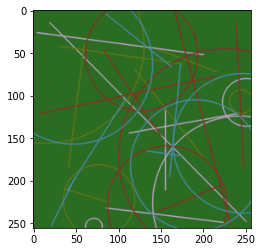

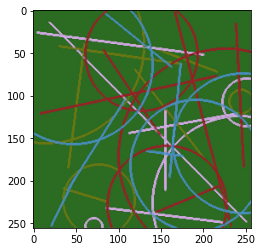

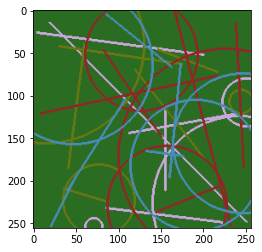

In [23]:
torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, Path("last_model.pt"))

with torch.no_grad():
    input, labels, _ = next(iter(train_dataloader))
    net_cpu = net.to(torch.device('cpu'))
    output = net_cpu(input)
    #clear_output(wait=True)
    plt.figure()
    plt.imshow (denormalized_numpy_image_from_tensor(input[0]))
    plt.figure()
    plt.imshow (denormalized_numpy_image_from_tensor(output[0]))
    plt.figure()
    plt.imshow (denormalized_numpy_image_from_tensor(labels[0]))

In [ ]:
# input, labels, _ = next(iter(train_dataloader))


(256, 256, 3)